# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

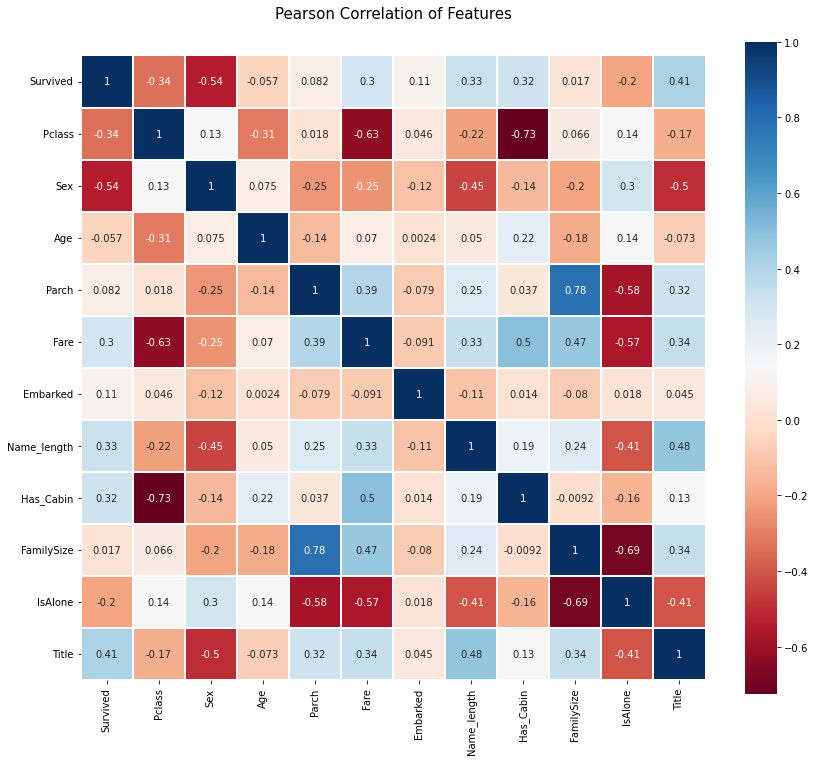

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

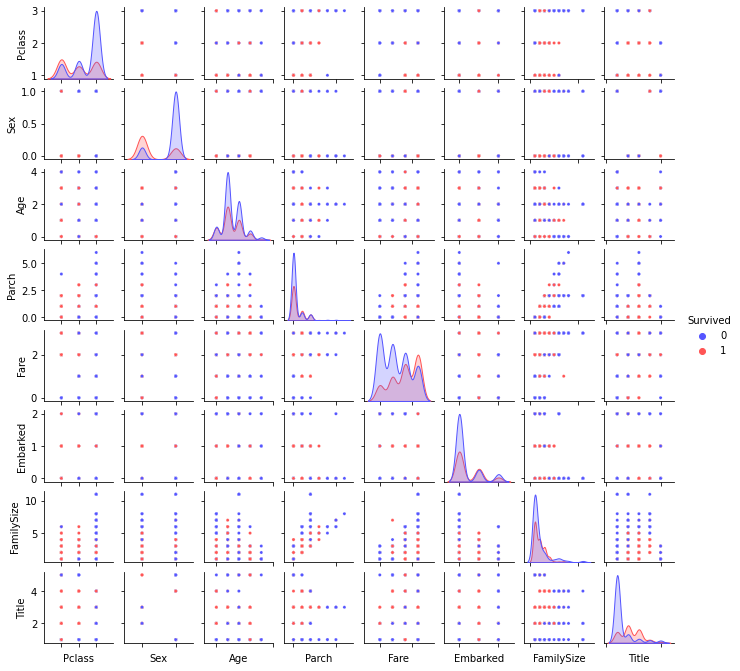

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [8]:
# создаем параметры для моделей для гридсерча
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)}

rfc_params = {'n_estimators': range(10, 100, 10),
              'min_samples_leaf': range(1, 5)}

dtc_params = {'max_depth' : range(1, 10, 1), 
              'min_samples_leaf' : range(1, 10, 2)}

svc_params = {'kernel': ['linear', 'rbf'], 
              'C': np.arange(0.1, 1, 0.2)}

gnb_params = {'var_smoothing': np.logspace(0,-9, num=100)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

knn_params = {'n_neighbors': range(1, 10)}

xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

In [9]:
targets = train.copy().Survived
data = train.copy().drop(columns='Survived')

In [10]:

x_train, x_test, y_train, y_test = train_test_split(data, 
                                                    targets,
                                                    train_size=0.7,
                                                    random_state=17)

gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(random_state=17)
dtc = DecisionTreeClassifier(random_state=17)
svc = SVC(random_state=17, probability=True)
gnb = GaussianNB()
lr = LogisticRegression(random_state=17)
knn = KNeighborsClassifier()
xgb = XGBClassifier(n_estimators=40, random_state=17)


### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [11]:
gbc_grid = GridSearchCV(gbc, gbc_params, cv=skf, n_jobs = -1)
rfc_grid = GridSearchCV(rfc, rfc_params, cv=skf, n_jobs = -1)
dtc_grid = GridSearchCV(dtc, dtc_params, cv=skf, n_jobs = -1)
svc_grid = GridSearchCV(svc, svc_params, cv=skf, n_jobs = -1)
gnb_grid = GridSearchCV(gnb, gnb_params, cv=skf, n_jobs = -1)
lr_grid = GridSearchCV(lr, lr_params, cv=skf, n_jobs = -1)
knn_grid = GridSearchCV(knn, knn_params, cv=skf, n_jobs = -1)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=skf, n_jobs = -1)

models_grid = [gbc_grid, rfc_grid, dtc_grid, svc_grid, gnb_grid, lr_grid, knn_grid, xgb_grid]
models_name = ['GradientBoostingClassifier', 'RandomForestClassifier', 
                    'DecisionTreeClassifier', 'SVC', 'GaussianNB',
                    'LogisticRegression', 'KNeighborsClassifier', 'XGBClassifier']


In [12]:
for i, model in enumerate(models_grid):
    model.fit(x_train, y_train)
    print(f'Лучшие параметры для {models_name[i]} - {model.best_params_}')

Лучшие параметры для GradientBoostingClassifier - {'learning_rate': 0.2}
Лучшие параметры для RandomForestClassifier - {'min_samples_leaf': 2, 'n_estimators': 90}
Лучшие параметры для DecisionTreeClassifier - {'max_depth': 7, 'min_samples_leaf': 5}
Лучшие параметры для SVC - {'C': 0.1, 'kernel': 'linear'}
Лучшие параметры для GaussianNB - {'var_smoothing': 0.0002310129700083158}
Лучшие параметры для LogisticRegression - {'C': 0.7}
Лучшие параметры для KNeighborsClassifier - {'n_neighbors': 1}
Лучшие параметры для XGBClassifier - {'eta': 0.1, 'min_child_weight': 1, 'n_estimators': 15, 'subsample': 0.9000000000000001}


In [13]:
# проверяем модели на тестовых данных, записываем результаты метрик и создаем метаматрицу для обучения метамодели
meta_mtrx = np.empty((x_test.shape[0], len(models_grid)))
data_test = test.copy()
score = pd.DataFrame()
models_predicted = pd.DataFrame()
for n, model in enumerate(models_grid):
    predicted = model.predict(x_test)
    model_pred = model.predict(data_test)
    

    accuracy = accuracy_score(y_test, predicted)
    
    score[models_name[n]] = [accuracy]
    models_predicted[models_name[n]] = [model_pred]
    meta_mtrx[:, n] = model.predict(x_test)
    
#     print(f'Модель: {models_name[n]}: \
#     \nAccuracy - {accuracy} \
#     \nRecall - {recall} \
#     \nPrecision - {precision} \
#     \nf1 - {f1} \
#     \nroc_auc - {roc_auc} \
#     \nroc_auc_0 - {roc_auc_0} \
#     \nroc_auc_1 - {roc_auc_1} \
#     \n_____________')
    

### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [14]:
# создаем метамодель, ищем лучшие параметры и обучаем ее на метаматрице
meta = XGBClassifier(n_estimators=40, random_state=17)
meta_grid = GridSearchCV(meta, xgb_params, cv=skf, n_jobs = -1)
meta_grid.fit(meta_mtrx, y_test)
meta_grid.best_params_


{'eta': 0.4,
 'min_child_weight': 4,
 'n_estimators': 80,
 'subsample': 0.30000000000000004}

### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [15]:
# делаем функцию для стекинга
def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, train_size=None, cv=5):
    if train_size is None:
        
        meta_mtrx = np.empty((data_train.shape[0], len(models)))
        for n, model in enumerate(models):
            model.fit(data_train, targets_train)
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv=cv, method='predict')
        
        meta_model = meta_alg.fit(meta_mtrx, targets_train)
        
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
        
        meta_predict = meta_alg.predict(meta_mtrx_test)
        
        if targets_test is not None:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')
    
    elif train_size > 0 and train_size < 1:
        
        x_train, x_test, y_train, y_test = train_test_split(data_train, 
                                                    targets_train,
                                                    train_size=train_size,
                                                    random_state=17)

        meta_mtrx = np.empty((x_test.shape[0], len(models)))
        for n, model in enumerate(models):
            model.fit(x_train, y_train)
            meta_mtrx[:, n] = model.predict(x_test)
        
        meta_model = meta_alg.fit(meta_mtrx, y_test)
        
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
            
        meta_predict = meta_alg.predict(meta_mtrx_test)       
       
        return meta_predict
    

In [16]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [17]:
y_train = train.copy().Survived
x_train = train.copy().drop(columns='Survived')
x_test = test.copy()


In [18]:
# # x_train, x_test, y_train, y_test = train_test_split(data, 
# #                                                     targets,
# #                                                     train_size=0.7,
# #                                                     random_state=17)

# rfc = rfc_grid.best_estimator_
# gbc = gbc_grid.best_estimator_
# lr = lr_grid.best_estimator_
# svc = svc_grid.best_estimator_
# meta_alg = meta_grid.best_estimator_

# models = [rfc, gbc, lr, svc]

# data_train, targets_train, data_test, targets_test = x_train, y_train, x_test, y_test

# meta_predictions = stacking(models, meta_alg, data_train, targets_train, data_test, targets_test, test_size=0.3, cv=5)


# берем модели с лучшими параметрами, запускаем функцию стекинга и записываем результаты в датасет с метриками 
gbc = gbc_grid.best_estimator_
rfc = rfc_grid.best_estimator_
dtc = dtc_grid.best_estimator_
svc = svc_grid.best_estimator_
gnb = gnb_grid.best_estimator_ 
lr = lr_grid.best_estimator_
knn = knn_grid.best_estimator_
xgb = xgb_grid.best_estimator_
meta_alg = meta_grid.best_estimator_

models = [gbc, rfc, dtc, svc, gnb, lr, knn, xgb]

data_train, targets_train, data_test, targets_test = x_train, y_train, x_test, y_test

meta_predictions = stacking(models, meta_alg, data_train, targets_train, data_test, targets_test, train_size=0.7, cv=5)

In [19]:
models = [gbc, rfc, dtc, svc, gnb, knn, xgb]
models_name = ['GradientBoostingClassifier', 'RandomForestClassifier', 
               'DecisionTreeClassifier', 'SVC', 'GaussianNB',
               'KNeighborsClassifier', 'XGBClassifier' ]
estim = []
for i, model in enumerate(models):
    tup = (models_name[i], model)
    estim.append(tup)
    

In [20]:
# создаем готовую модель стекинга, обучаем, получаем результаты метрик, записываем результат
targets = train.copy().Survived
data = train.copy().drop(columns='Survived')
data_test = test.copy()

sclf = StackingClassifier(estimators=estim, 
                          final_estimator=SVC(random_state=17),
                          stack_method ='predict')

x_train, x_test, y_train, y_test = train_test_split(data, 
                                                    targets,
                                                    train_size=0.7,
                                                    random_state=17)
sclf.fit(x_train, y_train)
sclf_predicted = sclf.predict(data_test)



In [21]:
models_predicted


,GradientBoostingClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC,GaussianNB,LogisticRegression,KNeighborsClassifier,XGBClassifier
0,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ..."


In [22]:
gbc_prediction = models_predicted.iloc[0,0]
rfc_prediction = models_predicted.iloc[0,1]
dtc_prediction = models_predicted.iloc[0,2]
svc_prediction = models_predicted.iloc[0,3]
gnb_prediction = models_predicted.iloc[0,4]
lr_prediction  = models_predicted.iloc[0,5]
knc_prediction = models_predicted.iloc[0,6]
xgb_prediction = models_predicted.iloc[0,7]

In [23]:
print(gbc_prediction.shape)
print(rfc_prediction.shape)
print(dtc_prediction.shape)
print(svc_prediction.shape) 
print(gnb_prediction.shape) 
print(lr_prediction.shape)
print(knc_prediction.shape)
print(xgb_prediction.shape)

(418,)
(418,)
(418,)
(418,)
(418,)
(418,)
(418,)
(418,)


In [24]:
sclf_predicted.shape

(418,)

In [25]:
score

,GradientBoostingClassifier,RandomForestClassifier,DecisionTreeClassifier,SVC,GaussianNB,LogisticRegression,KNeighborsClassifier,XGBClassifier
0,0.772388,0.787313,0.75,0.787313,0.798507,0.798507,0.761194,0.783582


In [26]:
meta_predictions.shape

(418,)

In [27]:
PassengerId.shape

(418,)

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [28]:
def write_to_submission_file(predictions, PassengerID, out_file, columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [30]:
write_to_submission_file(sclf_predicted, PassengerId, out_file = 'Submission_sclf.csv')
write_to_submission_file(meta_predictions, PassengerId, out_file = 'Submission_mysc.csv')
write_to_submission_file(gbc_prediction, PassengerId, out_file = 'Submission_gbc.csv')
write_to_submission_file(rfc_prediction, PassengerId, out_file = 'Submission_rfc.csv')
write_to_submission_file(dtc_prediction, PassengerId, out_file = 'Submission_dtc.csv')
write_to_submission_file(svc_prediction, PassengerId, out_file = 'Submission_svc.csv')
write_to_submission_file(gnb_prediction, PassengerId, out_file = 'Submission_gnb.csv')
write_to_submission_file(lr_prediction, PassengerId, out_file = 'Submission_lr.csv')
write_to_submission_file(knc_prediction, PassengerId, out_file = 'Submission_knc.csv')
write_to_submission_file(xgb_prediction, PassengerId, out_file = 'Submission_xgb.csv')


### 6.
Каков результат score, полученного на соревновании?

Ваш ответ: Score: 0.77511